# Gradient-Based Optimization Demo

In [2]:
import SQcircuit as sq

import numpy as np
import torch
from matplotlib import pyplot as plt

## Introduction

In this notebook, we demonstrate the gradient-based optimization capability of SQcircuit. This can be used to optimize for a wide variety of loss functions including transverse and longitudinal sources of decoherence, flux and charge noise, and parameter sensitivity. In essence, any smooth and differentiable function that can be expressed in PyTorch can be optimized over. Here we focus on the specific case of optimizing a circuit parameters for a target optimization frequency $\omega_{10}$.

To begin using SQcircuit with backpropagation enabled, we first activate the PyTorch backend engine:

In [3]:
sq.set_engine('pytorch')

In this example, we consider optimization over the fluxonium circuit as this includes all three fundamental quantum circuit elements (junction, capacitor, and inductor).

The circuit diagram looks like the following:

<div>
<img src="https://docs.google.com/uc?export=download&id=1SbtZeSiwBffC_yeRCLZiH8rkgrMEQ5ez" width="300"/>
</div>

## Circuit Construction

In the following cell, we define the circuit elements and create a fluxonium circuit from these elements:

In [4]:
# Define loop
loop = sq.Loop(0.5)

# Define elements
J = sq.Junction(13, 'GHz', loops=[loop], requires_grad = True)
C = sq.Capacitor(5, 'fF', requires_grad = False)
L = sq.Inductor(400, 'nH', loops=[loop], requires_grad = False)

elements = {
    (0, 1): [J, L, C],
}

# Create circuit from elements
fluxonium = sq.Circuit(elements)
fluxonium.set_trunc_nums([400, ])

The next step is to diagonalize the circuit. This returns the first $n$ eigenvalues and eigenvectors, which we can use to build a more complex loss function.

In [5]:
efreqs, evecs = fluxonium.diag(2)
print(f"Eigenvalues shape: {efreqs.shape}")
print(f"Eigenvectors shape: {evecs.shape}")

Eigenvalues shape: torch.Size([2])
Eigenvectors shape: torch.Size([2, 400])


Let's start by printing the target operation frequency of our qubit:

In [6]:
def get_resonant_frequency(circuit):
  eigenvalues, _ = circuit.diag(2)
  omega = (eigenvalues[1] - eigenvalues[0])
  return omega

omega_10 = get_resonant_frequency(fluxonium)
print(f"Starting frequency: {omega_10} GHz")

Starting frequency: 0.47366126676493847 GHz


## Loss Function

We can now define our loss function in terms of the output $\omega$, for a target operation frequency of $\omega^*=2.4$ GHz. For consistency of units, we convert everything from GHz to Hz.

In [7]:
omega_target = 2.4 # GHz

def compute_loss(circuit, omega_target):
  omega = get_resonant_frequency(circuit)
  loss = (omega * 1e9 - omega_target * 1e9) ** 2
  return loss

initial_loss = compute_loss(fluxonium, omega_target)
print(f"Initial loss: {initial_loss}")

Initial loss: 3.7107809151620296e+18


## Optimization

In [8]:
fluxonium = sq.Circuit(elements)
fluxonium.set_trunc_nums([400, ])
fluxonium.diag(2)

loss_record, J_record, frequency_record = [], [], []
omega_initial = get_resonant_frequency(fluxonium)

# Define optimizer
optimizer = torch.optim.SGD(
    fluxonium.parameters,
    lr=1e2
)

for epoch in range(50):
  optimizer.zero_grad()
  print(f"Epoch #{epoch}")

  # Compute qubit frequency
  omega = get_resonant_frequency(fluxonium)
  frequency_record.append(omega.detach().numpy())
  print(f"Frequency: {omega} GHz")

  # Compute loss
  loss = compute_loss(fluxonium, omega_target)
  loss_record.append(loss.detach().numpy())
  print(f"Loss: {loss}")

  # Extract junction value
  J_value = J.get_value('GHz')
  print(f"J value: {J_value} GHz\n")
  J_record.append(J_value.detach().numpy())

  # Perform backprop
  loss.backward()

  # Update element params
  optimizer.step()

  # Update circuit
  fluxonium.update()

Epoch #0
Frequency: 0.4736612667648523 GHz
Loss: 3.710780915161389e+18
J value: 81.68140899333463 GHz

Epoch #1
Frequency: 0.5214667184933206 GHz
Loss: 3.528887289729588e+18
J value: 77.50707158432472 GHz

Epoch #2
Frequency: 0.5798962526124578 GHz
Loss: 3.3127776512542244e+18
J value: 72.96279918337456 GHz

Epoch #3
Frequency: 0.6525354108932495 GHz
Loss: 3.053632490181818e+18
J value: 67.99200866924889 GHz

Epoch #4
Frequency: 0.7444802883780728 GHz
Loss: 2.740745515568765e+18
J value: 62.53320878125297 GHz

Epoch #5
Frequency: 0.8629123898121884 GHz
Loss: 2.3626383213929697e+18
J value: 56.52865836620672 GHz

Epoch #6
Frequency: 1.0174862833833502 GHz
Loss: 1.911344176633038e+18
J value: 49.94765369467019 GHz

Epoch #7
Frequency: 1.2193354509393375 GHz
Loss: 1.39396877740846e+18
J value: 42.8414709509897 GHz

Epoch #8
Frequency: 1.475287477098472 GHz
Loss: 8.550932500105842e+17
J value: 35.45479259236882 GHz

Epoch #9
Frequency: 1.7719446168517186 GHz
Loss: 3.94453564301397e+17
J va

Let's take a look at our results! We can first observe how the loss changes over time:

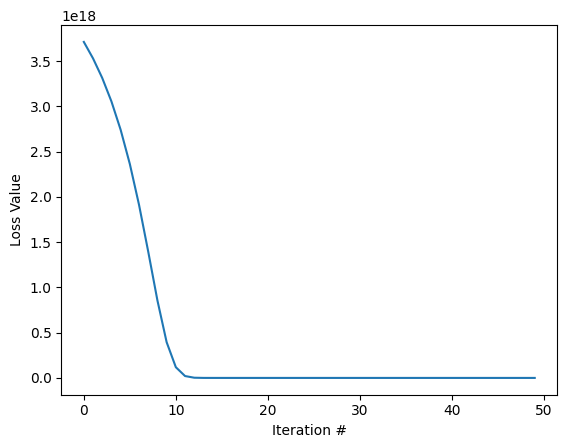

In [9]:
# Plot loss values
plt.xlabel('Iteration #')
plt.ylabel('Loss Value')
plt.plot(loss_record)

Then to ensure our circuit changes as intended as the loss function is reduced, we can also measure the convergence of our qubit frequency to the desired target frequency $\omega_{10}$:

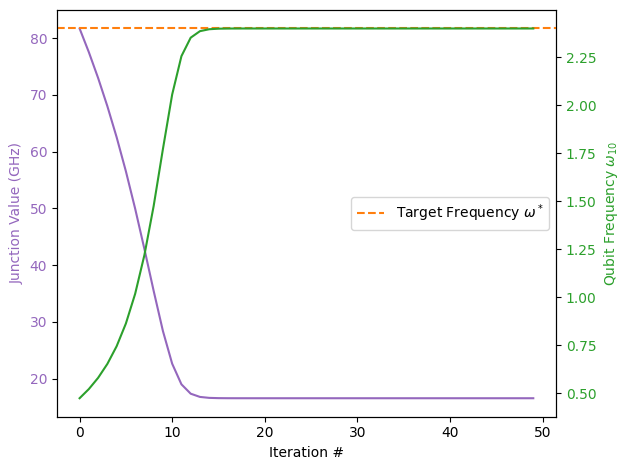

In [10]:
# Plot junction value vs. qubit frequency
fig, ax1 = plt.subplots()

color = 'tab:purple'
ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Junction Value (GHz)', color=color)
ax1.plot(J_record, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel(r'Qubit Frequency $\omega_{10}$', color=color)
ax2.axhline(y=omega_target, xmin=0, xmax=50,
            color='tab:orange', ls='--', label=r'Target Frequency $\omega^*$')
ax2.plot(frequency_record, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='center right')

fig.tight_layout()
plt.show()